# Objetivo del notebook

Este es el primer fichero Jupyter del proyecto, en el que trataremos de analizar los datos con los que contamos para llevar a cabo la modelización final. 

En este primer fichero Jupyter podemos hacer un acercamiento a una de las hipótesis planteadas, donde "afirmamos" que las fracturas en instancias positivas son lo sufientemente visibles como para ser detectadas por el modelo de clasificacion, e igualmente, por el modelo YOLO de detección. Dicho de otra forma, buscamos saber si nosotros mismos somos capaces de distinguir correctamente un hueso fracturado de uno sano, en radiografías de clases contrarias.

---

<br>
<br>
<br>

## Importar las librerías a utilizar

En la siguiente celda se importan todas las librerías que se utilizan en el presente fichero Jupyter.

In [47]:
# Librerías de procesamiento y manipulación de datos
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2 as cv

# Otros
import os
from tqdm import tqdm

---

<br>
<br>
<br>

## Cargando el conjunto de datos

El conjunto de datos que he tomado de Kaggle, cuenta con subconjuntos de entrenamiento, validación y testing predefinidos, lo que acelera nuestro proceso de modelización. No obstante, este proceso tendrá lugar en otro fichero Jupyter. Por el momento, voy a cargar algunas imagenes, con las que poder arañar de forma superficial las características del dataset.

In [2]:
# Tamaño de los subsets
N_TRAIN = len(os.listdir(os.path.join("../data/train/", "fractured")) + os.listdir(os.path.join("../data/train/", "not fractured")))
N_VAL = len(os.listdir(os.path.join("../data/val/", "fractured")) + os.listdir(os.path.join("../data/val/", "not fractured")))
N_TEST = len(os.listdir(os.path.join("../data/test/", "fractured")) + os.listdir(os.path.join("../data/test/", "not fractured")))


print(f"Número de instancias iniciales para el conjunto de entrenamiento: {N_TRAIN} imágenes.")
print(f"Número de instancias iniciales para el conjunto de validación: {N_VAL} imágenes.")
print(f"Número de instancias iniciales para el conjunto de testing: {N_TEST} imágenes.")

Número de instancias iniciales para el conjunto de entrenamiento: 9247 imágenes.
Número de instancias iniciales para el conjunto de validación: 829 imágenes.
Número de instancias iniciales para el conjunto de testing: 506 imágenes.


Contamos con un buen número de instancias de partida. No obstante, para lograr una precisión superior, es seguro que llevaremos a cabo un proceso de aumento de datos. A pesar de ello, deberemos de entrenar una red convolucional con el conjunto inicial, de forma que podamos validar otra de las hipótesis formuladas inicialmente.

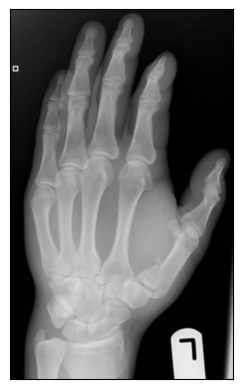

In [20]:
# Ruta del directorio que contiene las imágenes
image_dir = os.path.join("../data/train/", "fractured")

# Listo las imágenes en el directorio, ignorando .ipynb_checkpoints y archivos no válidos
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f != ".ipynb_checkpoints"]

# Selecciono la primera imagen
image = image_files[0]

# Leo la primera imagen del directorio y la cargo en memoria con cv2.imread()
img = cv.imread(os.path.join(image_dir, image))

# Asigno 3 canales de color (RGB) a la imagen
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Muestro la imagen
plt.xticks([]), plt.yticks([])
plt.imshow(imgRGB, cmap='gray', interpolation='bicubic')
plt.show()


El código anterior nos permite mostrar una imagen, previamente cargada en memoria por el método .imread() de OpenCV. Esta imagen corresponde a una instancia del conjunto de entrenamiento, concretamente, a la primera instancia de instancias positivas (radiografías que representan una fractura). 

Si vemos la imagen en busca de la fractura, podemos apreciar como la radiografía muestra una fractura en un huevo de la muñeca del sujeto.

![Fractura señalada dentro de la primera imagen](../src/images_notebooks/fractura_1.png)

En este caso, se aprecia como la fractura es lo suficientemente visible como para poder apreciarla a simple vista. Para confirmar entonces la primera hipótesis, voy a mostrar varias de las imagenes que pertenecen a este subset de datos.

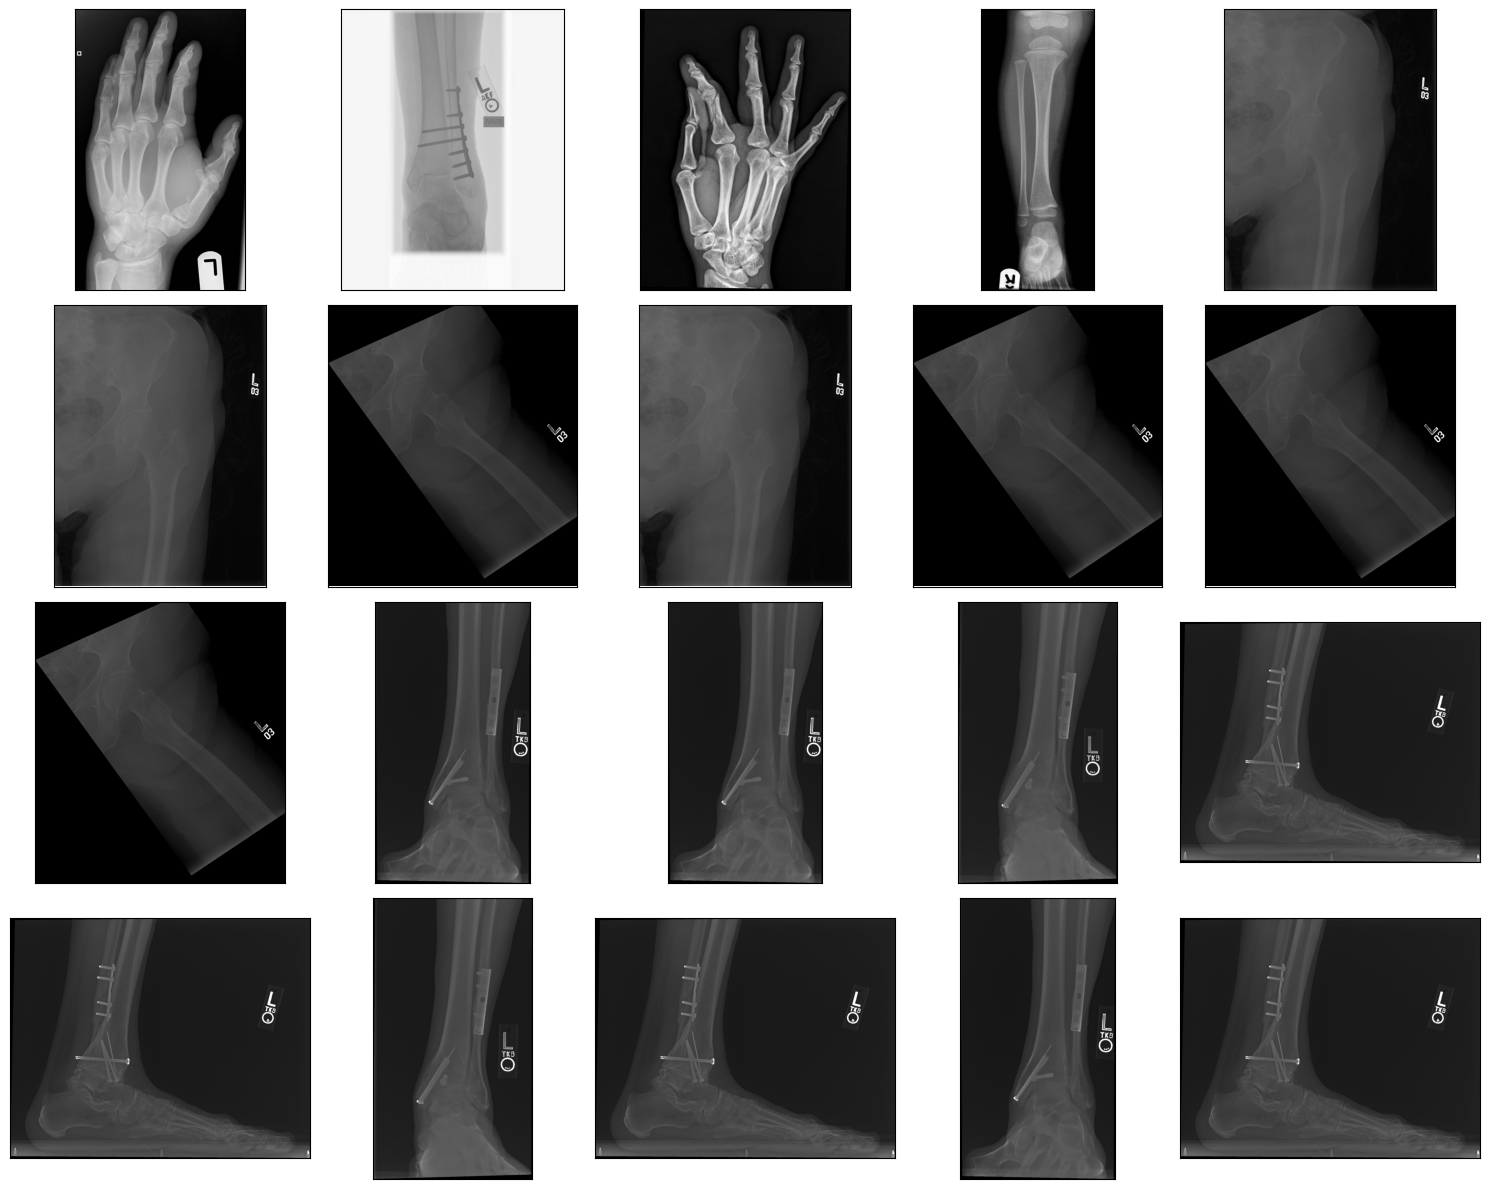

In [23]:
# Selecciono las primeras 20 imágenes
selected_images = image_files[:20]

## Visualización 

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Itero sobre las imágenes seleccionadas y las muestro en la figura
for i, image in enumerate(selected_images):
    
    img = cv.imread(os.path.join(image_dir, image))
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Obtengo el eje correspondiente en la cuadrícula
    ax = axes[i // 5, i % 5]

    # Muestro la imagen en el subplot correspondiente
    ax.imshow(imgRGB)
    ax.set_xticks([]), ax.set_yticks([]) 

plt.tight_layout()
plt.show()

Entiendo que imagenes como las de la última fila, en las que se observa claramente una serie de objetos ajenos al hueso mostrado, son producto de una intervención quirúrgica previa, de modo que sí se encuentra fractura el hueso en cuestión.

Por otro lado, he revisado detenidamente algunas imágenes en las que no aprecio fractura alguna dentro de los plots de la figura, y lo cierto es que sí que se aprecia la fractura de algún hueso en la radiografía. Un ejemplo es la imagen 3 de la primera fila:

![Imagen en la que se señala la fractura detectada en la radiografía](../src/images_notebooks/fractura_2.jpeg)

---

<br>
<br>
<br>

Revisando detenidamente las imágenes con las que estamos trabajando, es cierto que las fracturas, una vez vistas, son lo suficientemente claras como para poder advertirlas a simple vista. De esta forma, puedo validar una de las hipótesis inicialmente planteadas:   

* **Los patrones visuales en las radiografías de huesos fracturados son lo suficientemente distintos como para ser reconocidos por un modelo de Deep Learning.**

Si bien es cierto que aun no hemos entrenado al modelo de Deep Learning, lo cierto es que si nosotros mismos no somos capaces de diferencias imágenes positivas de negativas, es dificil apuntar a un modelo que obtenga un buen rendimiento, por lo que poder apreciar correctamente las diferencias entre las categorías es un indicio positivo de que los modelos que entrenemos también sean capaces de ello.

## Características del conjunto de datos

Debido a que nuestro dataset completo está formado por imágenes, y no por datos tabulares, no podemos acceder a información que nos permita comprender de una manera más profunda el dataset, como insight que revelan los datos a medida que profundizamos en ellos. 

A pesar de ello, también contamos con información valiosa que utilizará nuestra red, como son las dimensiones de las imagenes, o los canales de color con los que estas se han guardado.

In [38]:
# Revisamos las dimensiones de las primeras 20 imágenes positivas del conjunto de entrenamiento

for i, image in enumerate(selected_images):   # selected_images contiene las 20 primeras instancias
    
    img = cv.imread(os.path.join(image_dir, image))
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    print(f"Dimensiones de la imagen {i + 1}: {imgRGB.shape}")

Dimensiones de la imagen 1: (1024, 617)
Dimensiones de la imagen 2: (2928, 2328)
Dimensiones de la imagen 3: (1024, 761)
Dimensiones de la imagen 4: (1024, 408)
Dimensiones de la imagen 5: (2021, 1517)


Se aprecia que las imagenes contienen resoluciones diferentes, lo cual es incompatible con un modelo de Machine Learning. Para solventar este problema, normalizaremos todas las imágenes a unas dimensiones específicas, que ayuden a definir una capa de entrada concreta en nuestras redes compatibles con todas las imágenes.

Por otra parte, las imágenes han sido almacenadas con 3 canales de color (RGB). Para reducir la complejidad de nuestros modelos, y debido a que las radiografías se aprecian en escala de grises, se procesarán las diferentes imágenes para conservarlas en una escala que simplifique las dimensiones de los modelos.

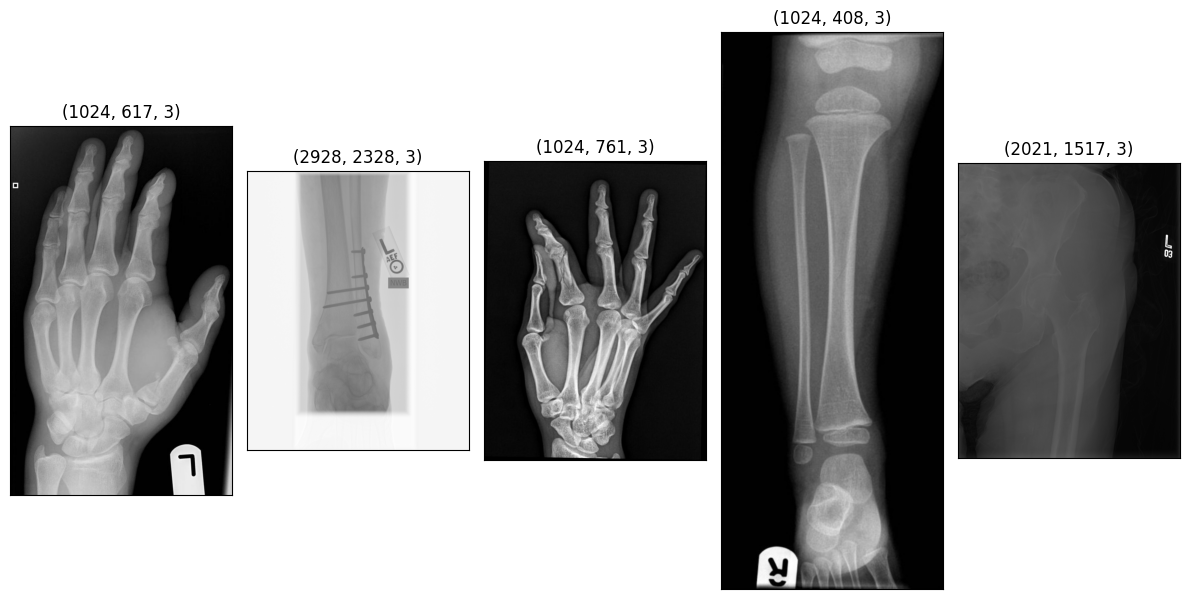

In [42]:
## Comparación entre imágenes con 3 canales de color

# Primeras 5 imágenes con 3 canales de color
selected_images = image_files[:5]

## Visualización 
fig, axes = plt.subplots(1, 5, figsize=(12, 10))

# Itero sobre las imágenes seleccionadas y las muestro en la figura
for i, image in enumerate(selected_images):
    
    img = cv.imread(os.path.join(image_dir, image))
    
    # Obtengo el eje correspondiente en la cuadrícula
    ax = axes[i % 5]

    # Muestro la imagen en el subplot correspondiente
    ax.imshow(img)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(img.shape)

plt.tight_layout()
plt.show()

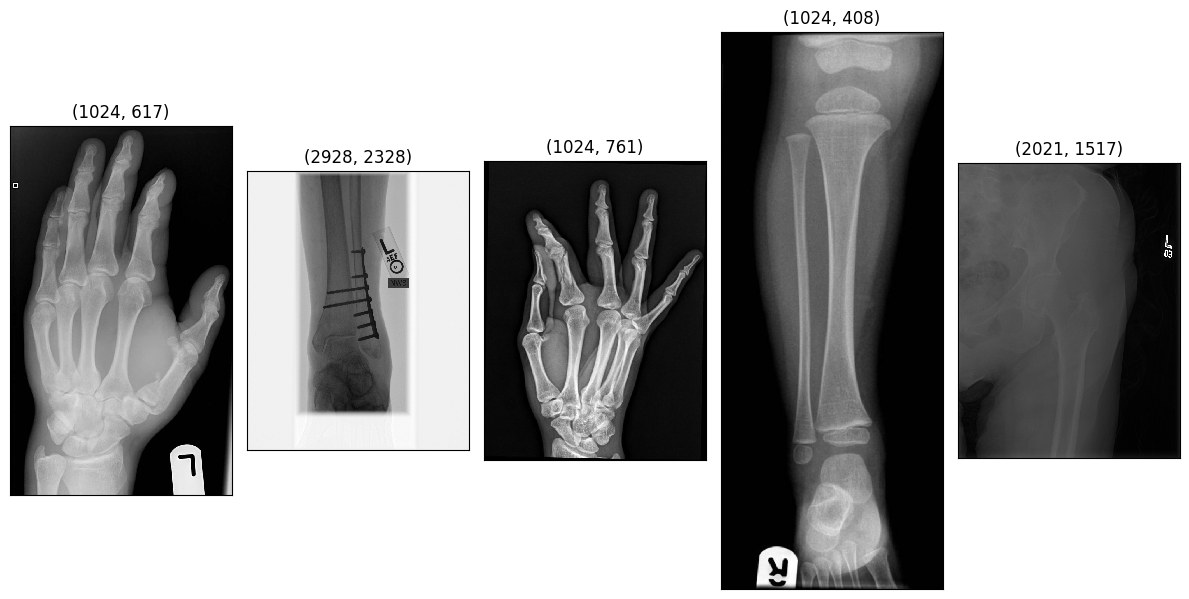

In [41]:
# Primeras 5 imágenes a escala de grises

## Visualización 
fig, axes = plt.subplots(1, 5, figsize=(12, 10))

# Itero sobre las imágenes seleccionadas y las muestro en la figura
for i, image in enumerate(selected_images):
    
    img = cv.imread(os.path.join(image_dir, image))
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    ax = axes[i % 5]

    # Muestro la imagen en el subplot correspondiente
    ax.imshow(img_gray, cmap='gray', interpolation='none')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(img_gray.shape)

plt.tight_layout()
plt.show()

Vemos que no se aprecian diferencias en las imagenes, de forma que el proceso de conversión a escala de grises no será un impedimento para el modelo (no captará menos información), si no que le ayudará en su proceso de aprendizaje.

---

<br>
<br>
<br>

## Procesamiento del dataset

El procesamiento que aplicaré en los conjuntos de datos, se divide en dos pasos diferente:

* Estandarización de las dimensiones de las imágenes a 224x224.
* Almacenar las imágenes en escala de grises.


In [48]:
# Defino un nuevo directorio donde alojar los nuevos datasets
datasets_path = "../data/"
new_datasets_path = "../processed_data/"

if not os.path.exists(new_datasets_path):
    os.mkdir(new_datasets_path)

# Itero cada uno de los subconjuntos en el directorio "data/"
for subset in tqdm(os.listdir(datasets_path)):

    if subset != ".ipynb_checkpoints":

        # Creo una nueva carpeta para cada uno de los subsets
        subset_path = os.path.join(new_datasets_path, subset)
        if not os.path.exists(subset_path):
            os.mkdir(subset_path)

        for class_ in os.listdir(os.path.join(datasets_path, subset)):
            
            # Creo una nueva carpeta para cada una de las clases
            class_path = os.path.join(subset_path, class_)
            if not os.path.exists(class_path):
                os.mkdir(class_path)

            # Para cada una de las clases, itero sobre el listado de imágenes contenido dentro, las cargo y proceso en memoria
            for image in tqdm(os.listdir(os.path.join(datasets_path, subset, class_))):
                
                img_path = os.path.join(datasets_path, subset, class_, image)
                img = cv.imread(img_path)

                if img is not None:
                    # Defino una copia de la imagen
                    img_resized = cv.resize(img, (224, 224))

                    # Transformo la copia a escala de grises
                    img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

                    # Defino la ruta de destino para la imagen procesada
                    save_path = os.path.join(class_path, image)
                    
                    # Conservo la copia dentro del directorio os.path.join(new_datasets_path, subset, class_)
                    cv.imwrite(save_path, img_gray)

                else:
                    print(f"Error al cargar la imagen {img_path}")

print("Procesamiento completado.")

100%|██████████| 238/238 [00:01<00:00, 174.70it/s]

  6%|▌         | 261/4606 [00:01<00:25, 173.26it/s]

Error al cargar la imagen ../data/train\fractured\159.jpg



  9%|▉         | 428/4606 [00:02<00:17, 232.75it/s]

Error al cargar la imagen ../data/train\fractured\2.jpg



 11%|█         | 492/4606 [00:02<00:26, 156.87it/s]

Error al cargar la imagen ../data/train\fractured\26(1).jpg



100%|██████████| 4606/4606 [00:20<00:00, 225.96it/s]

100%|██████████| 337/337 [00:02<00:00, 129.11it/s][A

100%|██████████| 4/4 [00:50<00:00, 12.62s/it]

Procesamiento completado.


## Revisando el contenido generado

Ya hemos generado las nuevas imagenes; copias de las anteriores, pero aplicando los cambios mencionados antes, que nos ayudarán a mejorar la calidad de nuestros modelos.

In [51]:
# Para acabar, analizo si efectivamente las nuevas imágenes
# contienen las características que deseamos

# Ruta del directorio (train) que contiene las imágenes procesadas
image_dir = os.path.join("../processed_data/train/", "fractured")

# Listo las imágenes en el directorio, ignorando .ipynb_checkpoints y archivos no válidos
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f != ".ipynb_checkpoints"]

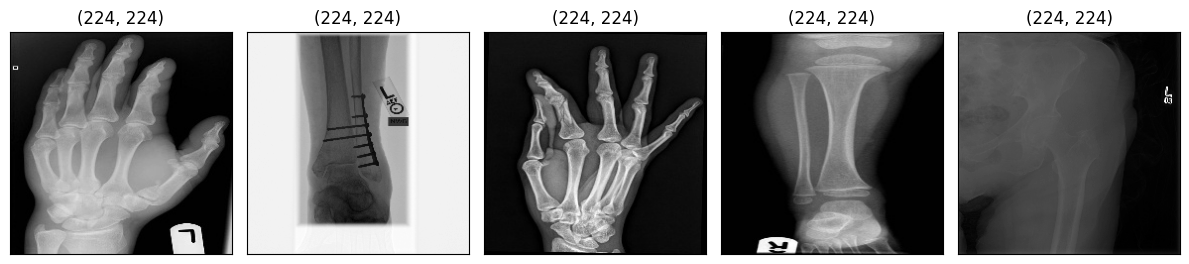

In [52]:
# Primeras 5 imágenes positivas del conjunto de entrenamiento
selected_images = image_files[:5]

## Visualización 
fig, axes = plt.subplots(1, 5, figsize=(12, 10))

# Itero sobre las imágenes seleccionadas y las muestro en la figura
for i, image in enumerate(selected_images):
    
    img_path = os.path.join(image_dir, image)
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    ax = axes[i % 5]

    # Muestro la imagen en el subplot correspondiente
    ax.imshow(img, cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(f"{img.shape}")

plt.tight_layout()
plt.show()

Finalmente, vemos como las imagenes procesadas se mantienen con dimensiones 224x224, a escala de grises.